# Solving Simflied Thick Ptychography Model Least Squares Problem

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a least_squares problem to reconstuct a thick sample.

The wave inversion is posed as a least-squares problem:

\begin{equation}
E(n) = \frac{1}{2} \sum_{i=1}^{N} \| p_i(n) - p_{\text{obs},i} \|^2_2,
\end{equation}

where $p_i$ and $p_{\text{obs},i}$ are the simulated and observed exit waves for the $i$-th probe position in Ptychography. 

$n(x,z)$ defines the refractive index of the volume

### 1. Import Libraries: Sample Space, Least Squares Solver and Visualisation

In [1]:
from thick_ptycho.sample_space.sample_space import SampleSpace
from thick_ptycho.reconstruction.least_squares import LeastSquaresSolver
from thick_ptycho.utils.visualisations import Visualisation

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "airy_disk"                 # Disk probe

# Constants
wavelength = 0.5#635  # μm
k0 = 2 * np.pi / wavelength

# background refractive index
nb = 1.0  # background refractive index
# Define refractive index perturbation
# delta: real part, beta: imaginary part (absorption)
delta = 0.01
beta = 0.01
refractive_index_perturbation = - delta - beta*1j 

# Spatial dimensions
xlims = [0, 40]  # μm
zlims = [0, 40]  # μm
continuous_dimensions = [xlims, zlims]


# Choose nz to satisfy paraxial resolution:
# Use approx. λ/4 axial resolution → ∆z ≈ λ / 4 ≈ 0.125 μm → nz = (z_range / ∆z)
z_range = zlims[1] - zlims[0]
dz = wavelength / 2
nz = int(z_range / dz)  
print(f"{nz=}")

# Discrete space parameters
probe_dimensions = [40]             # Discrete Probe dimensions
scan_points = 124  # image planes
step_size = 2                    # Step size in pixels


# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(f"{min_nx=}")
# Number of pixels in x directions
nx= 300
if nx < min_nx:
    nx = min_nx
discrete_dimensions = [
    nx,
    nz
    ]   

nz=160
min_nx=288


### 3. Create Sample Space, Add Objects and Visualise it.

Add rectangles with specified refractive indices to the sample space.

In [3]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    k0,            # wavenumber in 1/nm
    n_medium=nb,              # refractive index of the medium (default 1.0)
)
sample_space.summarize_sample_space()
visualisation = Visualisation(sample_space)

Summary of the scan (continuous):
    Sample space x: 40 um
    Sample space z: 40 um
    Probe Diameter: 5.35 um
    Number of scan points: 124
    Max Overlap: 5.08 um 



In [4]:
import numpy as np
gaussian_blur = 3

# Add 6 spheres of varying diameters and positions
common_side_length = 1  # μm diameter
common_depth = 1  # μm depth

sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  # μm diameter
                        centre=(100/300*xlims[1], 20/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(150/300*xlims[1], 80/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(200/300*xlims[1], 110/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(220/300*xlims[1], 80/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(125/300*xlims[1], 70/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(175/300*xlims[1], 20/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(100/300*xlims[1], 110/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)

sample_space.generate_sample_space()

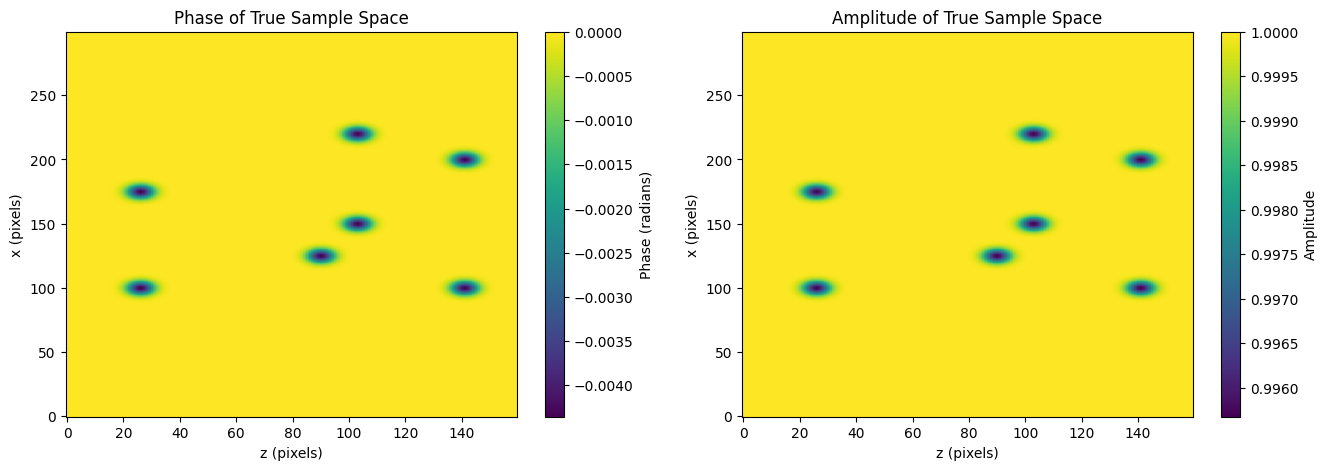

In [5]:
# Plot the true sample space
title = "True Sample Space"
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

true_phase = np.angle(sample_space.n_true)
true_amplitude = np.abs(sample_space.n_true)
vmin_phase = np.min(true_phase)
vmax_phase = np.max(true_phase)
vmin_amp = np.min(true_amplitude)
vmax_amp = np.max(true_amplitude)

# Get min and max values from the true sample space for color scaling
axs[0].set_title("Phase of True Sample Space")
im0 = axs[0].imshow(true_phase, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_phase, vmax=vmax_phase)
axs[0].set_xlabel('z (pixels)')
axs[0].set_ylabel('x (pixels)')
fig.colorbar(im0, ax=axs[0], label='Phase (radians)')

# Amplitude subplot
axs[1].set_title("Amplitude of True Sample Space")
im1 = axs[1].imshow(true_amplitude, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_amp, vmax=vmax_amp)
axs[1].set_xlabel('z (pixels)')
axs[1].set_ylabel('x (pixels)')
fig.colorbar(im1, ax=axs[1], label='Amplitude')

### 6. Solve Least Squares to Reconstruct Simulated Sample Space


Initializing Least Squares Solver...
Solving the true forward problem once to generate the dataset...
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
True Forward Solution computed in 0.91 seconds.
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)


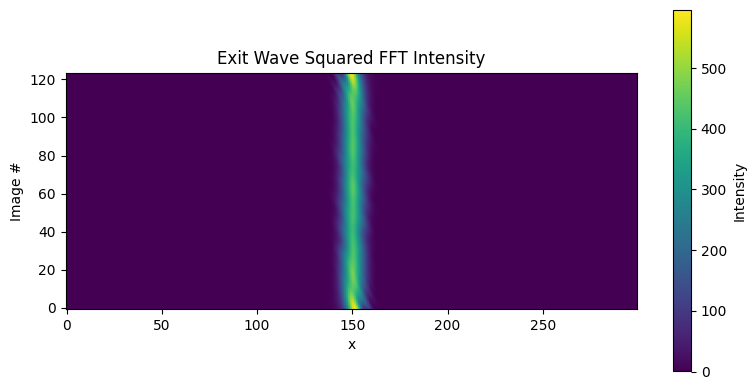

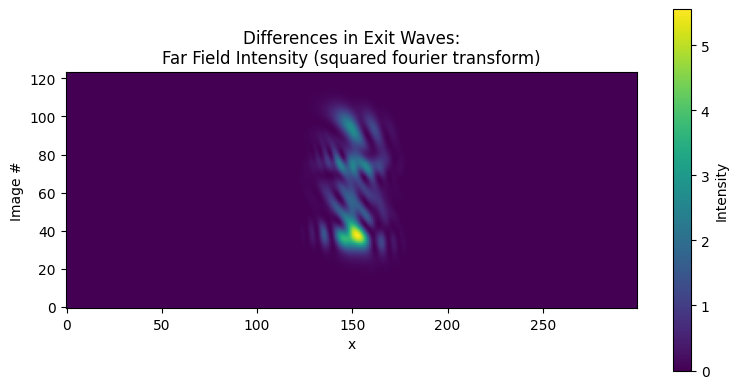

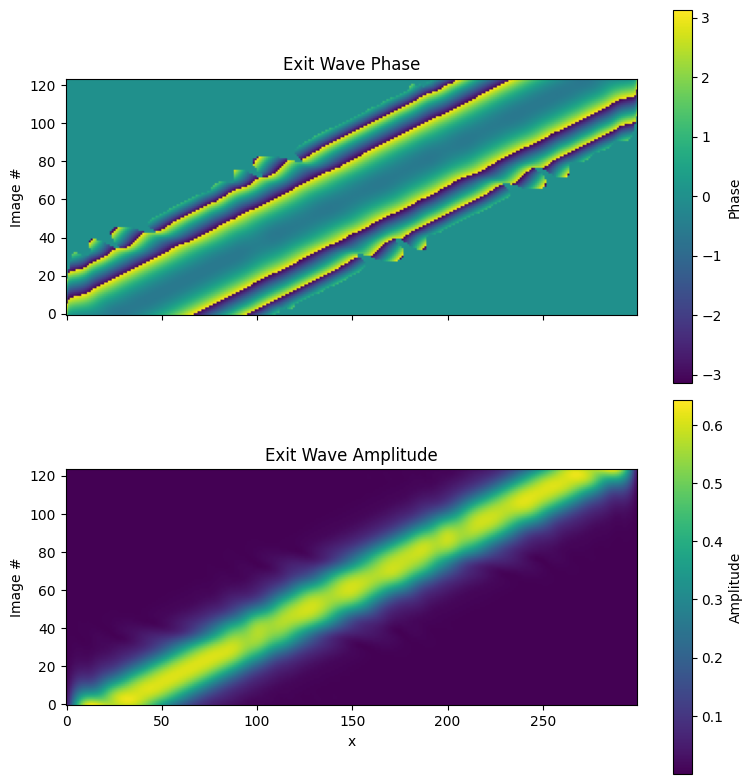

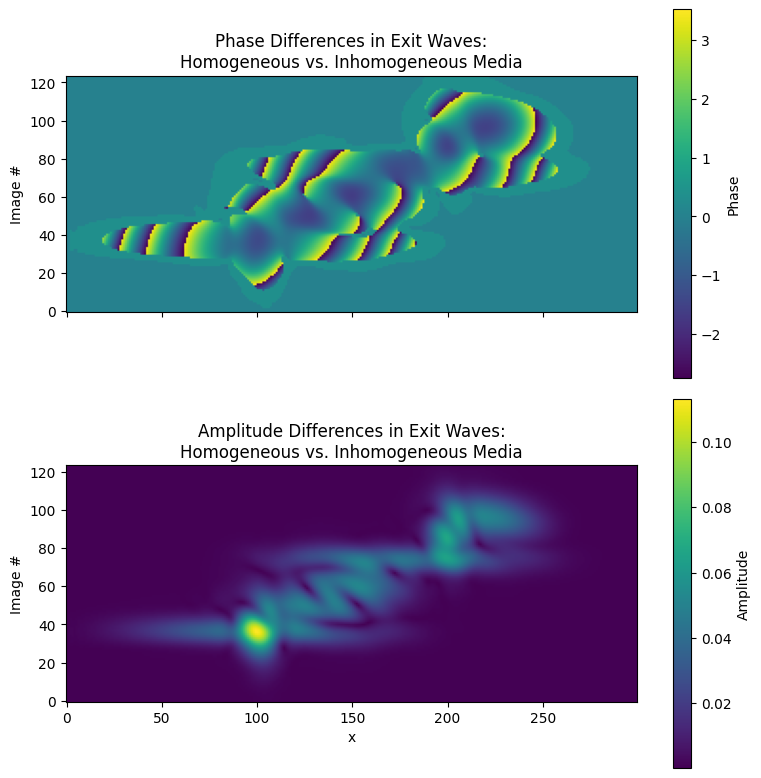

In [6]:
# Solve full system all-at-once or iteratively
least_squares = LeastSquaresSolver(sample_space,full_system_solver=False)

In [7]:
max_iters = 1000
reconstructed_sample_space, reconstructed_wave, residual_history = (
    least_squares.solve(max_iters=max_iters,
                        plot_forward=False,
                        plot_reverse=False,
                        plot_object=False,
                        solve_probe=False,
                        sparsity_lambda=0.0,
                        low_pass_filter=0.0)
)

# %load_ext line_profiler
# target_method = least_squares.solve
# %lprun -f target_method least_squares.solve(max_iters=max_iters,plot_forward=False, plot_reverse=False,plot_object=True,fixed_step_size=None,solve_probe=True,sparsity_lambda=0.0)#0.00002)


[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
Iteration 1/1000
    RMSE: 0.015428510576831377
    Iteration 1 took 3.00 seconds.
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
Iteration 2/1000
    RMSE: 0.014939259926184102
    Iteration 2 took 3.53 seconds.
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
Iteration 3/1000
    RMSE: 0.014472472681883546
    Iteration 3 took 3.35 seconds.
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
Iteration 4/1000
    RMSE: 0.014023646889045786
    Iteration 4 took 3.63 seconds.
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
Iteration 5/1000
    RMSE: 0.013592036968186448
    Iteration 5 took 3.27 seconds.
[BC debug] Impedance beta_x=(-0.9402515723270441+0j)
[B

### 7. Visualise the Residual History and Final Iterations

Residual History of Least Squares Objective Function


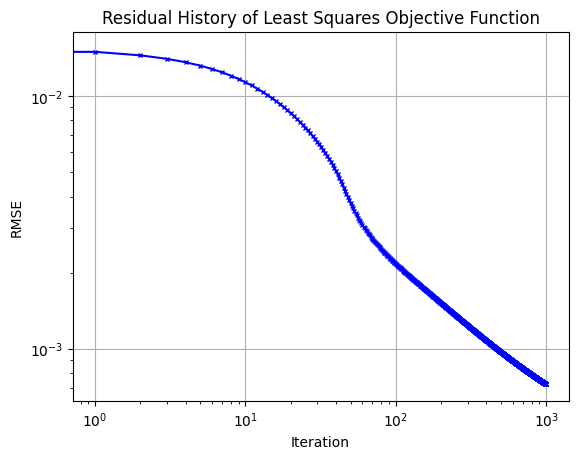

In [8]:
import matplotlib.pyplot as plt

# Log-log plot of residual
title ='Residual History of Least Squares Objective Function'
print(title)
plt.figure()
plt.loglog(residual_history, marker='x', linestyle='-', color='b',markersize=3)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title(title)
plt.grid(True)
plt.show()

Reconstructed Sample Space


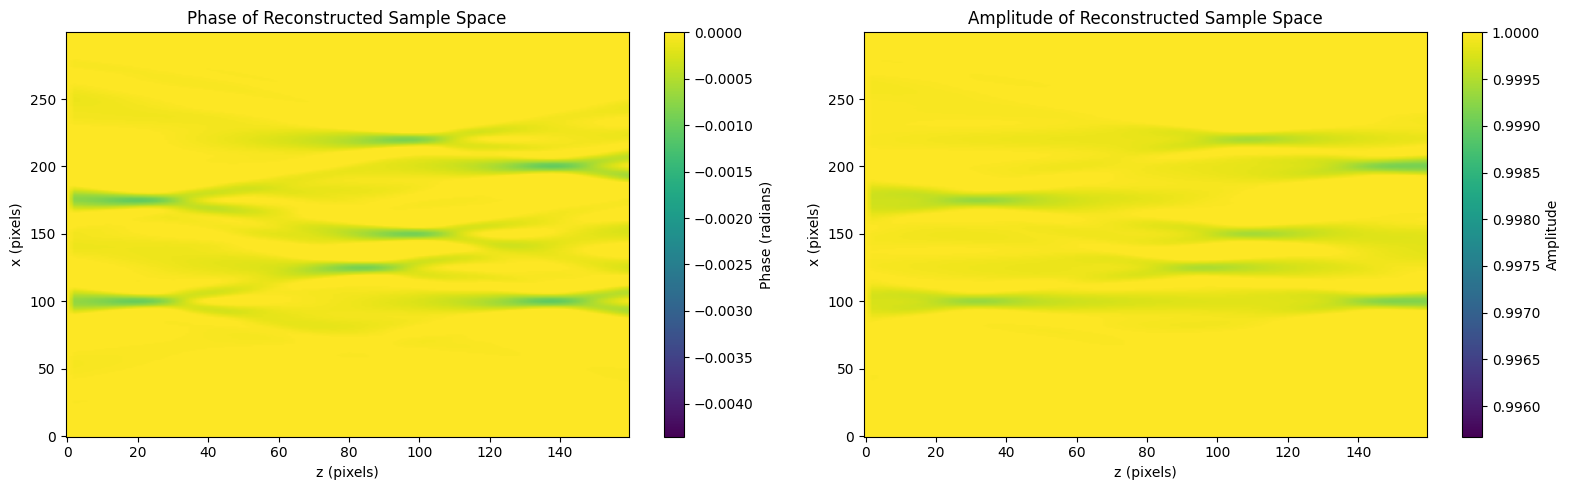

In [9]:
# Plot object field
title = "Reconstructed Sample Space"
print(title)

# Plot phase and amplitude of reconstructed sample space using subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Get min and max values from the true sample space for color scaling
true_phase = np.angle(sample_space.n_true)
true_amplitude = np.abs(sample_space.n_true)
phase = np.angle(reconstructed_sample_space)
amplitude = np.abs(reconstructed_sample_space)
vmin_phase = np.min(true_phase)
vmax_phase = np.max(true_phase)
vmin_amp = np.min(true_amplitude)
vmax_amp = np.max(true_amplitude)

# Phase subplot
axs[0].set_title("Phase of Reconstructed Sample Space")
im0 = axs[0].imshow(phase, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_phase, vmax=vmax_phase)
axs[0].set_xlabel('z (pixels)')
axs[0].set_ylabel('x (pixels)')
fig.colorbar(im0, ax=axs[0], label='Phase (radians)')

# Amplitude subplot
axs[1].set_title("Amplitude of Reconstructed Sample Space")
im1 = axs[1].imshow(amplitude, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_amp, vmax=vmax_amp)
axs[1].set_xlabel('z (pixels)')
axs[1].set_ylabel('x (pixels)')
fig.colorbar(im1, ax=axs[1], label='Amplitude')

plt.tight_layout()
plt.show()


Reconstructed Wave


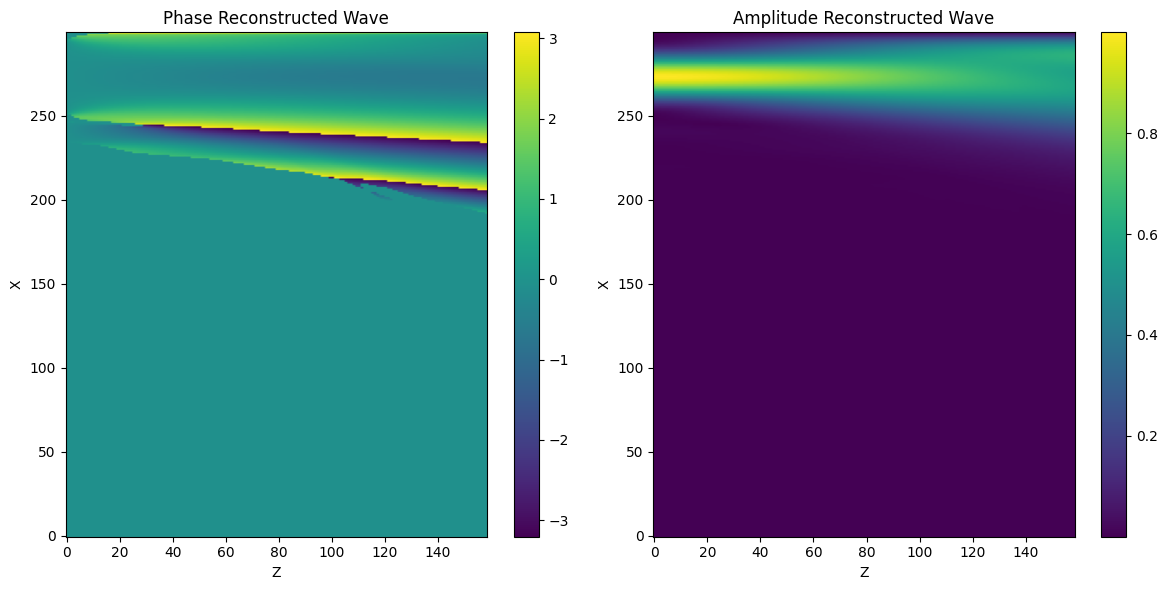

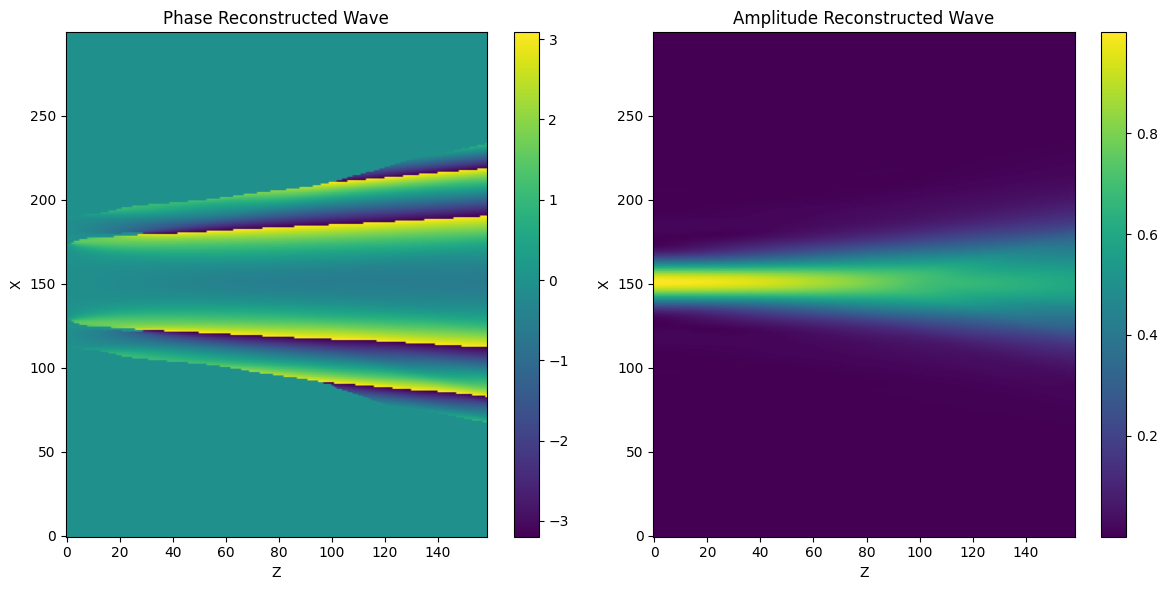

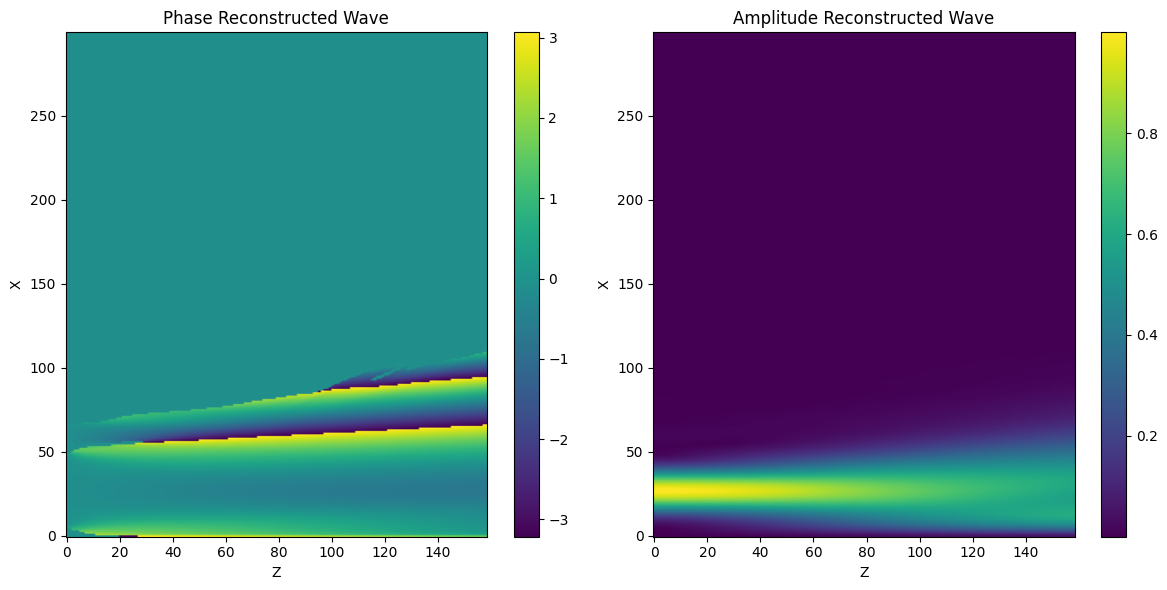

In [10]:
# Plot the reconstructed wave
title = "Reconstructed Wave"
print(title)
visualisation.plot(reconstructed_wave, title=title, probe_index=-1)
visualisation.plot(reconstructed_wave, title=title)
visualisation.plot(reconstructed_wave, title=title, probe_index=0)

In [11]:
# Profile the reconstruction
# %load_ext line_profiler
# %lprun -f SolveLeastSquares.compute_forward_model least_squares.solve(max_iters=max_iters, plot_forward=True, plot_object=True, fixed_step_size=False)
